In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pickle
import captum.attr 
from scipy import ndimage
import torch
import torch.nn as nn 
import torch.utils.data as data

In [4]:
# generate formulae of dimension d with signal dimension s 
def generate_formulae(d,s):
    X = np.array(np.meshgrid( *[[0, 1]]*d )).T.reshape(-1,d)

    Y = np.array(np.meshgrid( *[[0, 1]]*(2**s) )).T.reshape(-1,2**s)
    Y = np.hstack([Y]*(2**(d-s)))
    return X,Y

d = 4
s = 2
X,Y = generate_formulae(4,2)
print(Y[13,0:2**s]) # or formula 

[0 1 1 1]


In [5]:
# binary variable to rectangle in tile, 1: vertical, 0: horizontal (if zero = 1) else absent
def x_to_tile(x, n = 8, h = 4 , w = 4,  padding = 1, position = 'center', zero = 0):
    
    if position == 'random':
        s_y = np.random.randint(n-h-padding*2+1)+padding
        s_x = np.random.randint(n-w-padding*2+1)+padding
    else: 
        s_y = (n-h)//2
        s_x = (n-w)//2

    tile = np.zeros([n,n])
    if x == 1: 
        tile[s_y:s_y+h, s_x:s_x+w] = 1
    else: 
        tile[s_x:s_x+w, s_y:s_y+h] = zero
    return tile

x_to_tile(1,position = 'center')

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

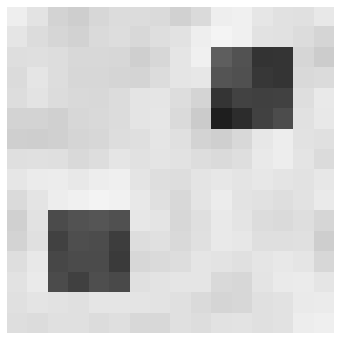

In [21]:
# binary data to image of tiles 
def X_to_image(X, r = 2, c = 2, position = 'center', zero = 0, p_noise = 0.4, sigma_smooth = 0.8):
    
    for i in range(r):
        a = [x_to_tile(X[i*c+j], position = position, zero = zero) for j in range(c)]
        b = np.hstack(a)
        if i == 0: 
            signal = np.array([]).reshape(0,b.shape[1])
        signal = np.vstack([signal,b])
    
    #noise = np.random.uniform(0,p_noise,signal.shape)
    noise = np.random.uniform(0,p_noise,signal.shape)
    smooth_noise = ndimage.gaussian_filter(noise, sigma = sigma_smooth)
    im = signal*(1-p_noise) + smooth_noise
    #im = signal + smooth_noise
    
    return im

fig = plt.figure(figsize=(6, 6))
plt.imshow(X_to_image(X[5]),cmap = 'Greys',vmin = 0, vmax = 1)
plt.axis('off')
plt.savefig('figures/rectangles0110.pdf')

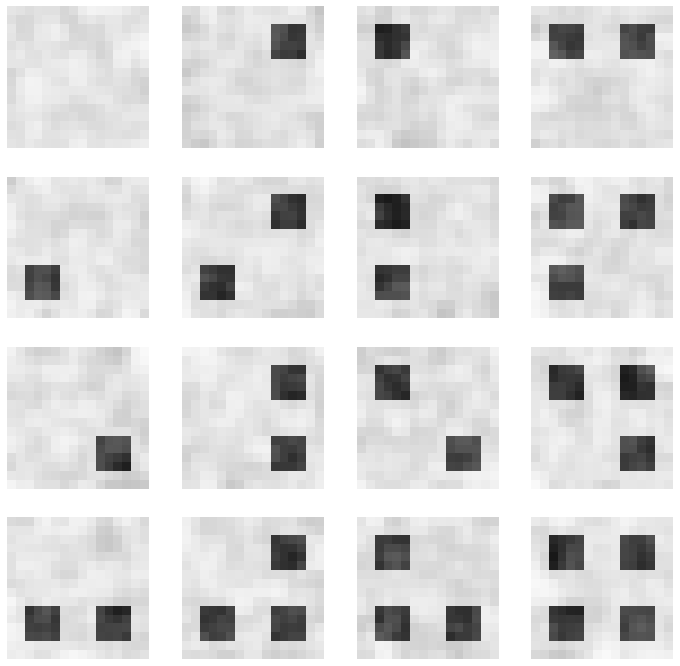

In [9]:
# show all 

I = np.array([X_to_image(X[i]) for i in range(X.shape[0])])

fig = plt.figure(figsize=(12, 12))
c = 4
r = 4
for i in range(1, c*r + 1 ):
    img = I[i-1]
    fig.add_subplot(r, c, i)
    plt.imshow(img,cmap = 'Greys',vmin = 0, vmax = 1)
    plt.axis('off')
plt.show()

In [10]:
def FCN(input_size,hidden_sizes,output_size):
    seq = []
    seq.append(torch.nn.Linear(input_size, hidden_sizes[0]))
    seq.append(torch.nn.ReLU())
    
    for i in range(len(hidden_sizes)-1):
        seq.append(torch.nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        seq.append(torch.nn.ReLU())
        
    seq.append(torch.nn.Linear(hidden_sizes[-1], output_size),)
        
    return torch.nn.Sequential(*seq)

def train_loop(dataloader, model, loss_fn, optimizer, verbose = True):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            if verbose:
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
   

def test_loop(dataloader, model, loss_fn,verbose = True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    if verbose:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        
    return correct 

In [17]:
# training and evaluation loop 

p_noise = 0.4
examples = np.array([X_to_image(X[i],p_noise = p_noise) for i in range(X.shape[0])])

def generate_explanations(X,y,rep_train,rep_test,n_models,data_use,n_epochs,explanation_methods,verbose):
    
    # dict for explanation/attributions 
    attributions = {}
    for key in explanation_methods:
        attributions[key] = []
    
    rep = rep_train + rep_test
    if data_use == 'id': 
        imgs = [X_to_image(X[i],p_noise = p_noise) for j in range(rep) for i in range(X.shape[0])]
    
    examples_ = torch.tensor(examples).view(-1,examples.shape[1]**2).float()
    
    for i in range(n_models):

        # create data 
        if data_use == 'iid':
            imgs = [X_to_image(X[i],p_noise = p_noise) for j in range(rep) for i in range(X.shape[0])]
        I = np.array(imgs) 

        X_train = torch.tensor(I[rep_test*X.shape[0]:]).view(-1,I.shape[1]**2).float()
        Y_train = torch.tensor(np.hstack([y]*rep_train))

        X_test = torch.tensor(I[:rep_test*X.shape[0]]).view(-1,I.shape[1]**2).float()
        Y_test = torch.tensor(np.hstack([y]*rep_test))

        train_dataloader = data.DataLoader(data.TensorDataset(X_train, Y_train),batch_size=100, shuffle = True,num_workers=1 )
        test_dataloader = data.DataLoader(data.TensorDataset(X_test, Y_test),batch_size=rep_test*X.shape[0], shuffle = False,num_workers=1 )

        # train model 

        model = FCN(X_train.shape[1], [X_train.shape[1]*2, 100,100,100],2)
        
        learning_rate = 1e-3
        batch_size = 100
    
        loss_fn = nn.CrossEntropyLoss() 
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        if n_epochs == 'min_generalize':
            max_epochs = 100
        else: 
            max_epochs = n_epochs

        for t in range(max_epochs):
            if verbose: 
                print(f"Epoch {t+1}\n")
            acc_train = train_loop(train_dataloader, model, loss_fn, optimizer, verbose)
            acc_test = test_loop(test_dataloader, model, loss_fn, verbose)

            if n_epochs == 'min_generalize' and acc_test == 1:
                break

        # explain model for examples

        targets = model(examples_).argmax(1)
    

        for key, val in explanation_methods.items():
            meth = val(model)
            if key == 'gradient':
                attr = meth.attribute(examples_, target = targets, abs = False)
            if key == 'integrated gradients':    
                baselines = torch.zeros(examples_[0:1].shape)
                attr = meth.attribute(examples_, baselines = baselines, target = targets, n_steps = 50)
            if key == 'gradient shap':
                baselines = torch.mean(examples_, dim = 0, keepdims = True)
                attr = meth.attribute(examples_, baselines = baselines, target = targets, n_samples = 5)
            else:
                attr = meth.attribute(examples_, target = targets) 

            attributions[key].append(attr.cpu().detach().numpy())

        print(f"Model {i+1}/{n_models} - Done!")
    return attributions


methods = {'gradient': captum.attr.Saliency, 
           'gradient x input': captum.attr.InputXGradient,
           'guided backprop': captum.attr.GuidedBackprop,
           'integrated gradients' : captum.attr.IntegratedGradients,
           'gradient shap': captum.attr.GradientShap,
           #'deeplift': captum.attr.DeepLift,
           #'dls': captum.attr.DeepLiftShap
           }



attributions = generate_explanations(X,Y[13],
                                     rep_train = 100,
                                     rep_test = 10,
                                     n_models = 25, 
                                     data_use = 'id', 
                                     n_epochs = 'min_generalize', 
                                     explanation_methods = methods,
                                     verbose = False)


Model 1/25 - Done!


/Applications/anaconda3/lib/python3.7/site-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/Applications/anaconda3/lib/python3.7/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


Model 2/25 - Done!
Model 3/25 - Done!
Model 4/25 - Done!
Model 5/25 - Done!
Model 6/25 - Done!
Model 7/25 - Done!
Model 8/25 - Done!
Model 9/25 - Done!
Model 10/25 - Done!
Model 11/25 - Done!
Model 12/25 - Done!
Model 13/25 - Done!
Model 14/25 - Done!
Model 15/25 - Done!
Model 16/25 - Done!
Model 17/25 - Done!
Model 18/25 - Done!
Model 19/25 - Done!
Model 20/25 - Done!
Model 21/25 - Done!
Model 22/25 - Done!
Model 23/25 - Done!
Model 24/25 - Done!
Model 25/25 - Done!


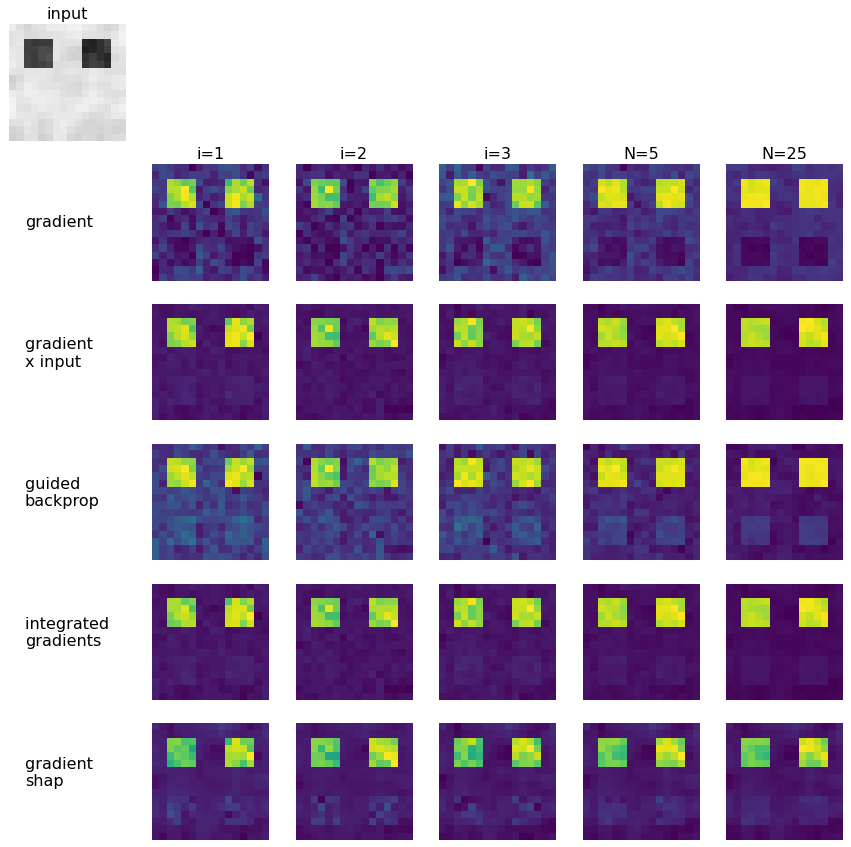

In [20]:
# final plot

new_labels= {'gradient':'gradient',
             'gradient x input': 'gradient \nx input', 
             'guided backprop': 'guided \nbackprop', 
             'integrated gradients':'integrated \ngradients',
             'gradient shap':'gradient \nshap'}


i = 3

N = [0,1,2,range(5),range(25)]
k = len(attributions)
s = 4
#fig = plt.figure()

img = examples[i]

fig, axs = plt.subplots(k+1,len(N)+1,figsize=(15,15))

axs[0,0].plot(k+1,len(N)+1, c)
im = axs[0,0].imshow(img, cmap = 'Greys',vmin = 0, vmax = 1)
axs[0,0].set_title('input',fontsize = 16)
#plt.colorbar(im,ax=axs[0,0])

        
for ax in axs.flat:
    ax.axis('off') 

r = 1
for l,a in attributions.items():  
    
    a = np.array(a)[:,i]
    
    #vmin=np.min(a, axis = 1, keepdims= True)
    #vmax=np.max(a ,axis = 1, keepdims = True)
    
    #a = (a - vmin)/(vmax-vmin)
    
    c = 1
    for n in N:
        if c == 1:
           axs[r,c].text(-18,8,new_labels[l],fontsize = 16)
        
        if type(n) == range:
            img = np.mean(a[n], axis = 0)
        else:
            img = a[n]
        
        img = img.reshape(examples.shape[1],examples.shape[1])
            
        axs[r,c].plot(len(N)+1,k, c)
        axs[r,c].imshow(img,cmap = 'viridis')#, vmin=0 , vmax = 1)
        if r == 1:
            if type(n) == range:
                txt = f'N={n[-1]+1}'
            else:
                txt = f'i={n+1}'
            axs[r,c].set_title(txt,fontsize = 16)
        c +=1
    
    r += 1

plt.savefig(f'figures/rectangles{N}.pdf',bbox_inches='tight',pad_inches=0)
plt.show()

